# Testing method of image preprocessing

In [1]:
# Import stuff
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

from ocr.helpers import implt
from ocr.datahelpers import loadWordsData

%matplotlib inline
# Increase size of plots
plt.rcParams['figure.figsize'] = (9.0, 5.0)

In [2]:
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    blur_size = int(4*sigma) | 1
    dx = alpha * cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1),
                                  ksize=(blur_size, blur_size),
                                  sigmaX=sigma)
    dy = alpha * cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1),
                                  ksize=(blur_size, blur_size),
                                  sigmaX=sigma)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    image =  map_coordinates(image, indices, order=1, mode='constant').reshape(shape)
    
    implt(image, 'gray')
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size,
                       [center_square[0]+square_size, center_square[1]-square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_CONSTANT)

    return image

In [3]:
# Load images
im = cv2.imread("data/words/uznale_1502630263.0986328.jpg", -1)

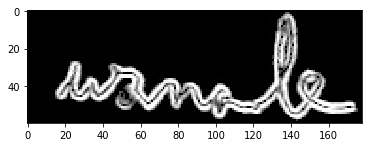

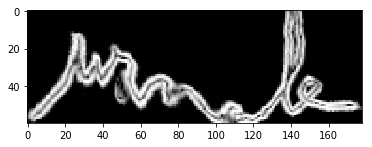

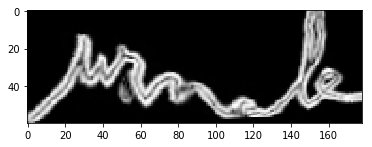

In [4]:

implt(im, 'gray')
# Apply transformation on image
im_trans = elastic_transform(im, im.shape[1] * 2, im.shape[1] * 0.08, im.shape[1] * 0.01)

# Display result
implt(im_trans, 'gray')

Loading words...
-> Number of words: 5069


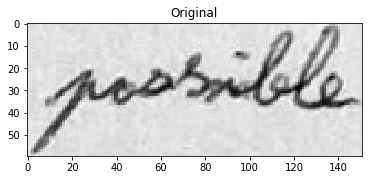

In [5]:
def genIdxs(arr):
    idxs = np.arange(arr.size)
    np.random.shuffle(idxs)
    return idxs

raw_images, _  = loadWordsData('data/words_raw/', False)
implt(raw_images[genIdxs(raw_images)[0]], 'gray', t='Original')

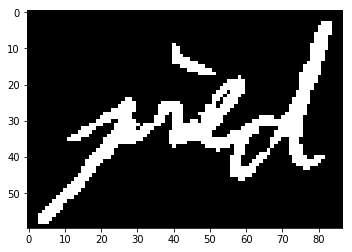

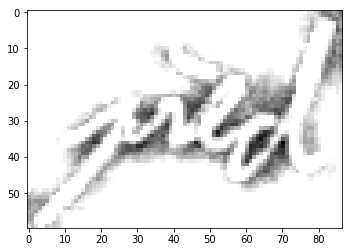

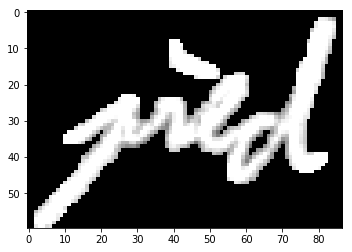

In [6]:
def normalization(img):
    ret, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th = 255 - th
    img = 255 - img
    implt(th, 'gray')
    
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))
    # convert from BGR to LAB color space
    lab = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), cv2.COLOR_RGB2LAB) 
    l, a, b = cv2.split(lab)  # split on 3 different channels

    l2 = clahe.apply(l)  # apply CLAHE to the L-channel

    lab = cv2.merge((l2,a,b))  # merge channels
    img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to B
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    ret, th2 = cv2.threshold(img2, 0, 255, cv2.THRESH_TRUNC+cv2.THRESH_OTSU)
    implt(th2, 'gray')
    
    
    kernel = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(th, kernel, iterations = 1)
    dilation = cv2.GaussianBlur(th,(3,3),0)
    res = cv2.bitwise_and(th2, th2, mask=dilation)
    implt(res, 'gray')

# Produce bad results for some images
normalization(raw_images[genIdxs(raw_images)[0]])

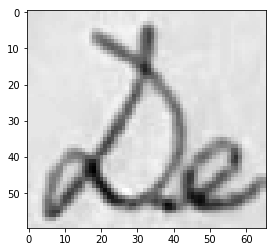

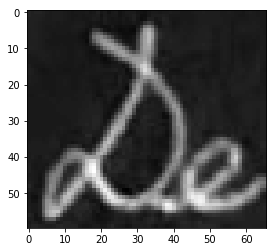

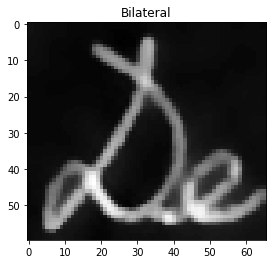

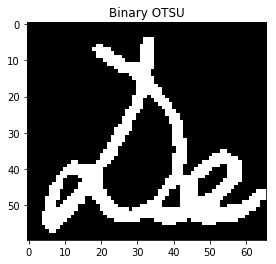

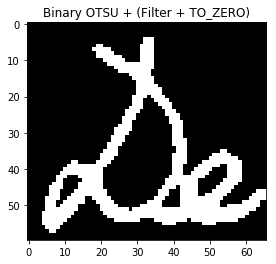

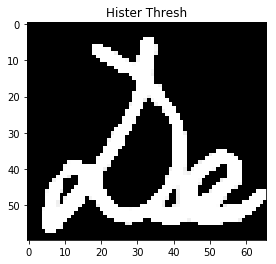

In [7]:
class HysterThresh:    
    def __init__(self, img):
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = 255 - img
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255        
        hist, bins = np.histogram(img.ravel(), 256, [0,256])
        
        self.high = np.argmax(hist) + 65
        self.low = np.argmax(hist) + 45
        self.diff = 255 - self.high
        
        self.img = img
        self.im = np.zeros(img.shape, dtype=img.dtype)
        self.hyster()
        
    def hyster_rec(self, r, c):
        h, w = self.img.shape
        for ri in [r-1, r+1]:
            for ci in [c-1, c+1]:
                if (h > ri >= 0
                    and w > ci >= 0
                    and self.im[ri, ci] == 0
                    and self.high > self.img[ri, ci] >= self.low):                    
                    self.im[ri, ci] = self.img[ri, ci] + self.diff
                    self.hyster_rec(ri, ci)                      
    
    def hyster(self):
        r, c = self.img.shape
        for ri in range(r):
            for ci in range(c):
                if (self.img[ri, ci] >= self.high):
                    self.im[ri, ci] = 255
                    self.img[ri, ci] = 255
                    self.hyster_rec(ri, ci)
                    
        implt(self.im, 'gray', 'Hister Thresh')


def fc1(img):    
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def fc2(img):
    add_img = 255 - cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img = 255 - img
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255        
    hist, bins = np.histogram(img.ravel(), 256, [0,256])
    
    img = img.astype(np.uint8)

    ret,thresh4 = cv2.threshold(img,np.argmax(hist)+10,255,cv2.THRESH_TOZERO)
    return add_img
    return cv2.add(add_img, thresh4, dtype=cv2.CV_8UC1)

def normalization2(img):
    ii = img[0]
    img = img[0]
    implt(img, 'gray')
    implt(255 - img, 'gray')
    img = cv2.bilateralFilter(img, 9, 15, 30)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    implt(255 - img, 'gray', 'Bilateral')
    implt(255 - fc1(img), 'gray', 'Binary OTSU')
    implt(fc2(img), 'gray', 'Binary OTSU + (Filter + TO_ZERO)')
    HysterThresh(cv2.bilateralFilter(ii, 10, 10, 30))

normalization2(raw_images[genIdxs(raw_images)])